In [15]:
import pathlib
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split
from keras.callbacks import CSVLogger
from tensorflow.keras import regularizers
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd

In [2]:
# get current working directory
cwd = pathlib.Path.cwd()

In [3]:
ds1, ds2, ds3 = tfds.load('patch_camelyon', split=['train[:30%]', 'test[:7%]', 'validation[:7%]'], 
                                data_dir=cwd, 
                                download=False, 
                                shuffle_files=True)

In [4]:
# Function to preprocess the images and labels
def preprocess(data):
    image = data['image']
    label = data['label']
    image = tf.image.resize(image, [224, 224])  # Resize to 224x224
    image = preprocess_input(image)  # Apply ResNet-specific preprocessing
    return image, label

In [5]:
# Apply the preprocessing function to the dataset
transfer_train_data = ds1.map(preprocess).batch(32)
transfer_validation_data = ds2.map(preprocess).batch(32)
transfer_test_data = ds3.map(preprocess).batch(32)

In [6]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 3s 0us/step


In [7]:
# Freeze the base model layers
for layer in resnet_model.layers:
    layer.trainable = False

In [8]:
# Transfer Model Architecture
transfer_model = tf.keras.Sequential([
    resnet_model, 
    tf.keras.layers.GlobalAveragePooling2D(),
    # Add a dropout layer for regularization
    tf.keras.layers.Dropout(0.5),  # 50% dropout rate
    # Add a dense layer with L2 weight regularization
    tf.keras.layers.Dense(
        1024,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)  # L2 regularization factor
    ),
    # Add another dropout layer before the final dense layer
    tf.keras.layers.Dropout(0.5),  # 50% dropout rate
    tf.keras.layers.Dense(
        1, 
        activation='sigmoid',
        kernel_regularizer=regularizers.l2(0.001)  # L2 regularization factor
    )
])

# Compile the model with an appropriate optimizer, loss, and metrics
transfer_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # or 'categorical_crossentropy' if you have more than two classes
    metrics=['accuracy']
)

# Print the summary of the model
transfer_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                        

In [9]:
# Create CSVLogger callback to save history
csv_filepath = 'ae_low_training_log.csv'
csv_logger = CSVLogger(csv_filepath, append=True)

history = transfer_model.fit(
    transfer_train_data,
    validation_data=transfer_validation_data,
    epochs=15,
    callbacks=[csv_logger]  # Add custom callback here
)

Epoch 1/15
2458/2458 [==============================] - 775s 314ms/step - loss: 0.6613 - accuracy: 0.8182 - val_loss: 0.4873 - val_accuracy: 0.8309
Epoch 2/15
2458/2458 [==============================] - 774s 315ms/step - loss: 0.4751 - accuracy: 0.8296 - val_loss: 0.4405 - val_accuracy: 0.8439
Epoch 3/15
2458/2458 [==============================] - 770s 313ms/step - loss: 0.4569 - accuracy: 0.8311 - val_loss: 0.4073 - val_accuracy: 0.8522
Epoch 4/15
2458/2458 [==============================] - 776s 316ms/step - loss: 0.4470 - accuracy: 0.8317 - val_loss: 0.4111 - val_accuracy: 0.8439
Epoch 5/15
2458/2458 [==============================] - 773s 314ms/step - loss: 0.4408 - accuracy: 0.8348 - val_loss: 0.4528 - val_accuracy: 0.8187
Epoch 6/15
2458/2458 [==============================] - 776s 316ms/step - loss: 0.4390 - accuracy: 0.8339 - val_loss: 0.4041 - val_accuracy: 0.8561
Epoch 7/15
2458/2458 [==============================] - 771s 314ms/step - loss: 0.4372 - accuracy: 0.8355 - val_

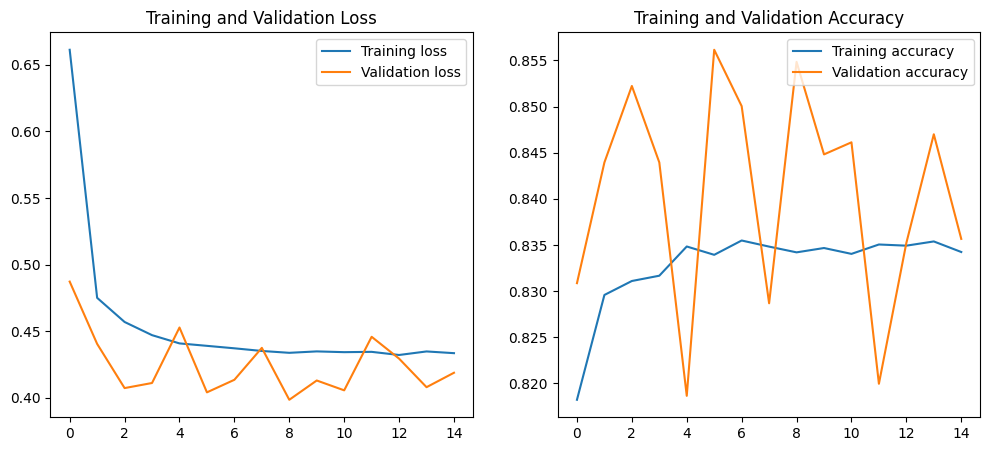

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.savefig('transfer_learning2_loss_acc.png')
plt.legend()

plt.show()

In [11]:
transfer_model.save('transfer_model2.h5')

In [20]:
# Predict on test data
predictions = transfer_model.predict(transfer_test_data)

# Threshold predictions at 0.5 to determine class labels for binary classification
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Create a DataFrame with predicted labels
predictions_pd = pd.DataFrame({
    'Id': list(range(len(predicted_labels))),
    'Predicted': predicted_labels,
})

predictions_pd.to_csv('final_predictions_transfer_learning2.csv', index=False)

# Collect true labels
true_labels = []
for images, labels in transfer_test_data.unbatch().take(len(predicted_labels)):
    true_labels.append(labels.numpy())

# Convert the true labels to a numpy array
true_labels = np.array(true_labels).flatten()  # Flattening if necessary

# Calculate the accuracy
accuracy = np.mean(predicted_labels == true_labels)
my_string = f"Accuracy: {accuracy * 100:.2f}%"
print(my_string)

# Write the accuracy to a csv file
with open("accuracy_transfer_learning2.csv", 'w') as file:
    file.write(my_string)


72/72 [==============================] - 23s 302ms/step
Accuracy: 80.86%
